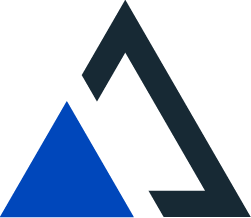

# AtScale Qlik Script and Master Element Generator 

In [ ]:
#pip install atscale

In [ ]:
%load_ext dotenv
%dotenv

In [ ]:
import os

from atscale.client import Client
from atscale.data_model import DataModel
from atscale.project import Project

Suppress warnings if you are using self signed certificates

In [ ]:
import requests
requests.packages.urllib3.disable_warnings() 

Connect to your AtScale Env

In [ ]:
# connect to AtScale
client:Client = Client(server=os.getenv("atscale-server"),
                organization='default',
                username=os.getenv("atscale-user"),
                password=os.getenv("atscale-password"),
                verify=False)
client.connect()


In [ ]:
# select the model to work with
project:Project = client.select_project()


In [ ]:
data_model:DataModel = project.select_data_model()

To avoid loading the complete Model. Choose the necessary attributes and measures (query names of the attributes)

In [ ]:
feature_list = ['Order Day_Date', 'Order YearMonth', 'Order Quarter', 'Order Month1', 'Gender', 'Color', 'salesamount1']

Generate the LOAD part of the Qlik Script, which will translate the query names to captions for the Qlik Users


In [ ]:
features = data_model.get_features(feature_list=feature_list)
feature_name_map = {key: value['caption'] for key, value in features.items()}
feature_type_map = {key: value['atscale_type'] for key, value in features.items()}
load_string = 'LOAD\n' + ',\n'.join([f'[{key}] as [{value}]' for key, value in feature_name_map.items()]) + ',\n;'
print(load_string)

Generate the SQL part for the Qlik script that actually loads the data from your datasource

In [ ]:
query = data_model.get_database_query(feature_list=list(feature_name_map.keys()))
select_string = query + '\n;' #add a semicolon to add additional envelope for delta load logic


Adjust the SQL for delta load. First adding an SELECT envelope to add a new WHERE clause for restricting the data from the last loaded date

In [ ]:
pre_select = 'SQL SELECT * FROM ('
post_select = ')WHERE `Order Day_Date` > "$(lastLoad)";'

select_string = pre_select + select_string[:len(select_string)-1] + post_select


Set your variables for 

**Datasource Connection:** Qlik Data Connection to your cloud data warehouse (Databricks, Snowflake, GBQ, Redshift, Synapse,...)

Example:
Qlik Cloud SaaS: "Demo Stream:atscale-datasource"
Qlik Sense Enterprise on Windows: "atscale-datasource"

**QVD filestore:** Qlik Filestorage.

Example:
Qlik Cloud Saas: "demo Stream:Datafiles
Qlik Sense Enterprise on Windows: "lib://QVD Store"



In [ ]:
conn_datasource = 'AtScale Demo:atscale_demo'
conn_filestore = 'lib://:DataFiles/'

Initialize the qlik script

In [ ]:
qlik_script = ""

Setting up default Qlik script header

In [ ]:

qlik_script += f"""
SET ThousandSep=',';
SET DecimalSep='.';
SET MoneyThousandSep=',';
SET MoneyDecimalSep='.';
SET MoneyFormat='$ ###0.00;-$ ###0.00';
SET TimeFormat='h:mm:ss TT';
SET DateFormat='M/D/YYYY';
SET TimestampFormat='M/D/YYYY h:mm:ss[.fff] TT';
SET FirstWeekDay=6;
SET BrokenWeeks=1;
SET ReferenceDay=0;
SET FirstMonthOfYear=1;
SET CollationLocale='en-US';
SET CreateSearchIndexOnReload=1;
SET MonthNames='Jan;Feb;Mar;Apr;May;Jun;Jul;Aug;Sep;Oct;Nov;Dec';
SET LongMonthNames='January;February;March;April;May;June;July;August;September;October;November;December';
SET DayNames='Mon;Tue;Wed;Thu;Fri;Sat;Sun';
SET LongDayNames='Monday;Tuesday;Wednesday;Thursday;Friday;Saturday;Sunday';
SET NumericalAbbreviation='3:k;6:M;9:G;12:T;15:P;18:E;21:Z;24:Y;-3:m;-6:μ;-9:n;-12:p;-15:f;-18:a;-21:z;-24:y';
"""

Add qlik script logic for delta load. If no QVD exists, then load since 1900-01-01

To get the last loaded date in the previous loaded data, the script needs to access the qvd file, located in the filestore connection.

In [ ]:
qlik_script += f"""

IF IsNull(FileTime('{conn_filestore}ORDER.qvd')) THEN
	LET lastLoad = '1900-01-01';
    TRACE no existing QVD found. Full load...;
END IF;

"""

Combine the load script, the sql select into the script:

In [ ]:

qlik_script += f"""

LIB CONNECT TO '{conn_datasource}';

ORDER:

{load_string}

{select_string}

"""

Combine the delta load with the previous load (QVD file)

In [ ]:
qlik_script += f"""
IF not(IsNull(FileTime('{conn_filestore}ORDER.qvd'))) THEN
  TRACE existing QVD found. Adding delta to QVD...;
  Concatenate (ORDER) 
  LOAD * FROM [{conn_filestore}ORDER.qvd]
  (qvd);
 
END IF ;

LET lastLoad = date(today(),'YYYY-MM-DD');

STORE ORDER INTO [{conn_filestore}ORDER.qvd](qvd);

"""

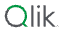

Direct upload script to qlik saas app

In [ ]:
#pip install qlik_sdk

In [ ]:
from qlik_sdk import (
    Apps, 
    Config, 
    AuthType, 
    Qlik, 
    NxLibraryMeasureDef,
    GenericMeasureProperties,
    GenericDimensionProperties, 
    NxLibraryDimensionDef,
    NxInfo,
    GenericDimension,
    UpdateApp
)
 
"""
Qlik Tenant Config
"""
base_url = os.getenv("qlik-saas-tenant")
api_key = os.getenv("qlik-saas-token")

"""
Setting Up Config
"""
conf = Config(host=base_url, auth_type=AuthType.APIKey, api_key=api_key)
q = Qlik(config=conf)
q.users.get_me().name

Load current app object

In [ ]:
AppsObject =Apps(conf)
atscale_app = AppsObject.get(os.getenv("qlik-saas-app-id"))

Push the new script into the app and reload the data

In [ ]:
with atscale_app.open():
    # Load in some data into the session document:
    script = atscale_app.set_script(qlik_script)
    atscale_app.do_reload()
    